- This filter was a zero phase 8th order low-passChebyshev Type II filter, with an 8Hz cutoff frequency anda 40dB stopband attenuation
- The filtered PPG signal wasdownsampled using linear interpolation at a frequency of 34.13Hz.
- Detrended- Polynomial 10th
- The PPG was then clipped within three standarddeviations of the mean, and the data was standardized


In [20]:
import os
import numpy as np
import pandas as pd
import h5py
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from scipy.signal import cheby2, filtfilt, butter, sosfiltfilt
from scipy.interpolate import interp1d
from joblib import Parallel, delayed

class prepro_pipeline_for_single_ppg():
    def __init__(self, signal, low_cutoff=0.1, high_cutoff=8):
        self.fs = 256
        self.signal = signal
        self.cheby_filtering(low_cutoff, high_cutoff)
        self.downsampling()
        self.standardization()

    def cheby_filtering(self, low_cutoff, high_cutoff):
        # Filter parameters
        order = 8               # 8th order
        stopband_attenuation = 40  # Stopband attenuation (dB)

        # Design the Chebyshev Type II filter
        nyquist = self.fs / 2
        low_normalized = low_cutoff / nyquist
        high_normalized = high_cutoff / nyquist
        sos = cheby2(order, stopband_attenuation, [low_normalized, high_normalized], btype='band', analog=False, output='sos')
        
        # Apply the zero-phase filter
        self.signal_filtered = sosfiltfilt(sos, self.signal)

    def downsampling(self):
        # Down Sampling
        fs_downsampled = 34.13  # 목표 샘플링 주파수 (Hz)

        # 시간 벡터 계산
        n_samples = self.signal.shape[0]
        t_original = np.arange(n_samples) / self.fs  # 원래 시간 벡터

        n_samples_downsampled = int(n_samples * (fs_downsampled / self.fs))  # 다운샘플링 후 샘플 개수
        t_downsampled = np.linspace(0, t_original[-1], n_samples_downsampled)  # 다운샘플링된 시간 벡터

        interpolator = interp1d(t_original, self.signal_filtered, kind='linear')  # 선형 보간 함수 생성
        self.signal_filtered_downsampled = interpolator(t_downsampled)  # 다운샘플링된 신호 생성
        self.fs_downsampled = fs_downsampled


    def standardization(self):
        self.signal_filtered_downsampled_standardized = (self.signal_filtered_downsampled - np.mean(self.signal_filtered_downsampled)) / np.std(self.signal_filtered_downsampled)


In [3]:
# Define a function to process a single subject
def process_subject(subject_id, path_h5, path_save):
    if subject_id in os.listdir(path_save):
        return  # Skip if already processed

    # Load the PPG signal from the h5 file
    with h5py.File(os.path.join(path_h5, subject_id), "r") as hdf:
        signal = hdf["data"][:]

    # Process the signal using the preprocessing pipeline
    _prepro = prepro_pipeline_for_single_ppg(signal)

    # Save the processed signal to a new h5 file
    with h5py.File(os.path.join(path_save, subject_id), "w") as hdf:
        hdf.create_dataset("data", data=_prepro.signal_filtered_downsampled_standardized)

path_h5 = 'Y:/MESA_0.7.0/ppg'
path_save = 'Y:/MESA_0.7.0/ppg_preprocessed'

list_subject_id = os.listdir(path_h5)

# Parallel processing
_ = Parallel(n_jobs=-1)(
    delayed(process_subject)(subject_id, path_h5, path_save) for subject_id in tqdm(list_subject_id)
    )

  0%|          | 0/2056 [00:00<?, ?it/s]

Text(0.5, 1.0, 'mesa-sleep-2030.h5')

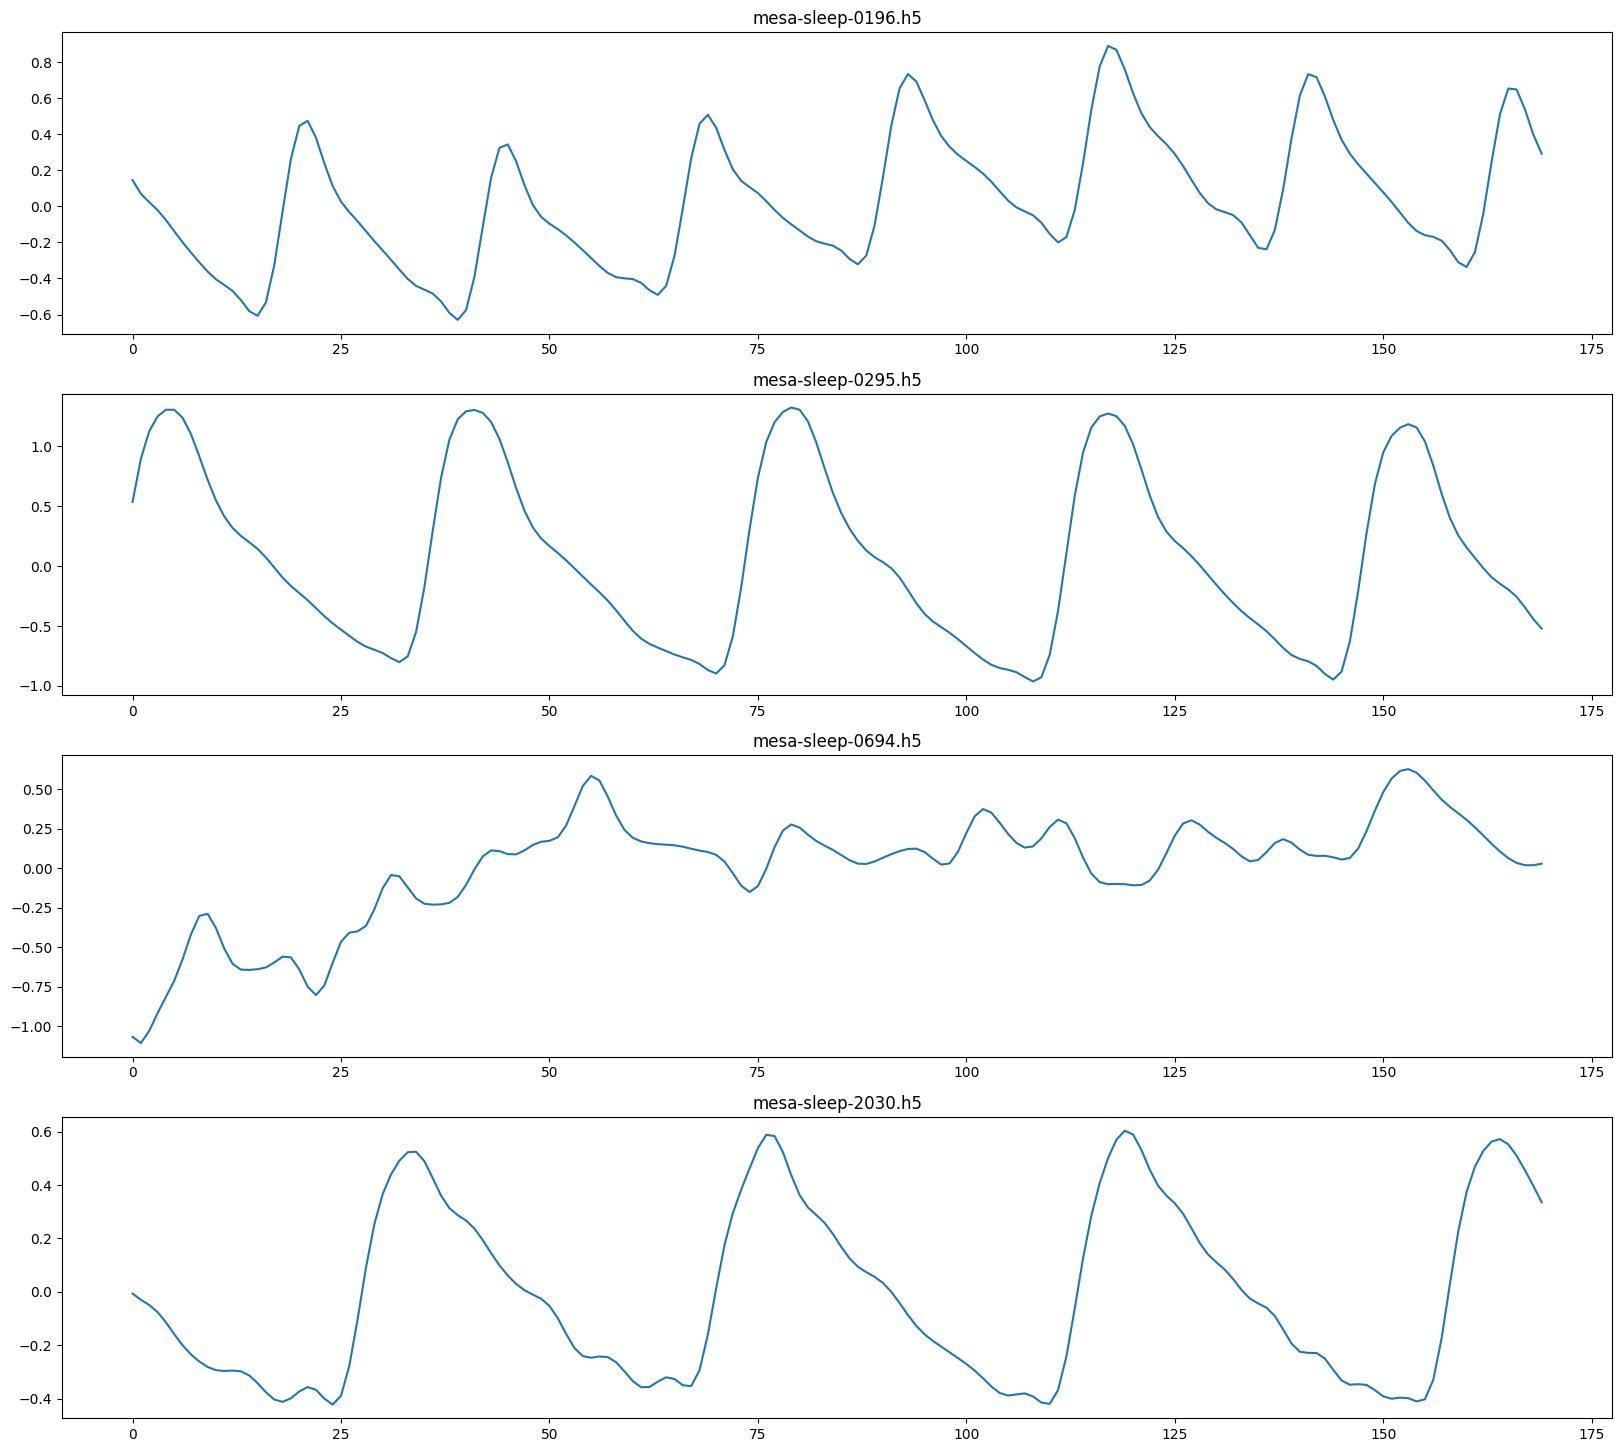

In [18]:
with h5py.File(os.path.join(path_save, list_subject_id[58]), "r") as hdf:
        signal_1 = hdf["data"][:]

with h5py.File(os.path.join(path_save, list_subject_id[80]), "r") as hdf:
        signal_2 = hdf["data"][:]

with h5py.File(os.path.join(path_save, list_subject_id[222]), "r") as hdf:
        signal_3 = hdf["data"][:]

with h5py.File(os.path.join(path_save, list_subject_id[600]), "r") as hdf:
        signal_4 = hdf["data"][:]

fs = 34.13
fig, axs = plt.subplots(4, 1, figsize=(20, 18))
axs[0].plot(signal_1[int(fs*600): int(fs*605)])
axs[0].set_title(list_subject_id[58])

axs[1].plot(signal_2[int(fs*600): int(fs*605)])
axs[1].set_title(list_subject_id[80])

axs[2].plot(signal_3[int(fs*600): int(fs*605)])
axs[2].set_title(list_subject_id[222])

axs[3].plot(signal_4[int(fs*600): int(fs*605)])
axs[3].set_title(list_subject_id[600])

In [11]:
list_subject_id[222]

'mesa-sleep-0694.h5'

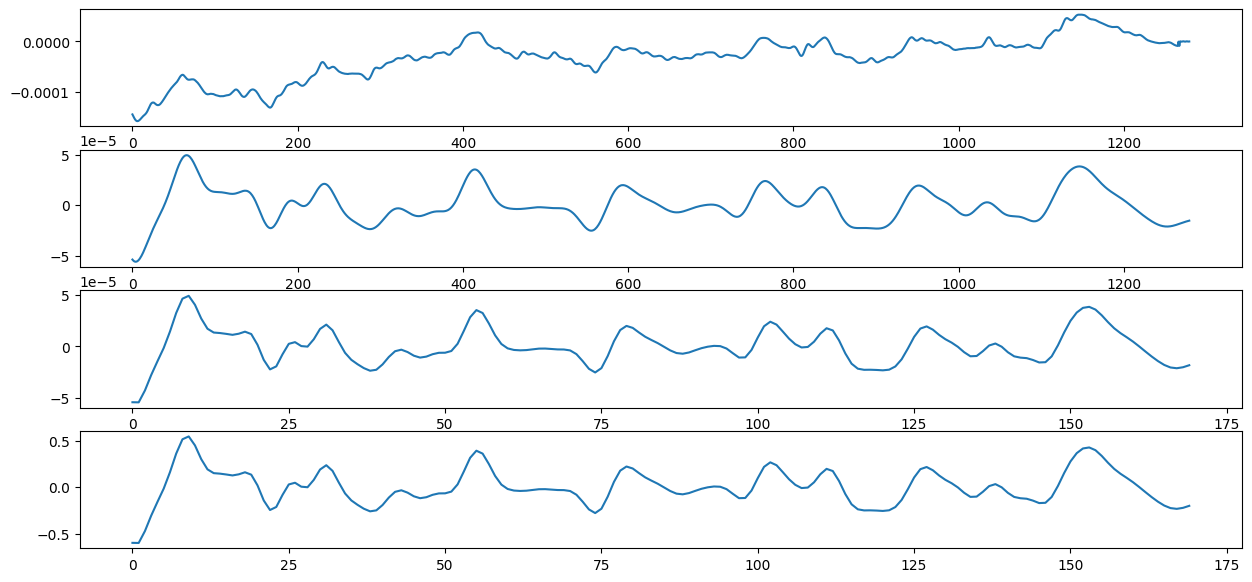

In [22]:
with h5py.File(os.path.join(path_h5, list_subject_id[222]), "r") as hdf:
    signal = hdf["data"][:]
    
_prepro = prepro_pipeline_for_single_ppg(signal, low_cutoff=0.5, high_cutoff=8)

fs = 256
fig, axs = plt.subplots(4, 1, figsize=(15, 7))
axs[0].plot(_prepro.signal[fs*600: fs*605])
axs[1].plot(_prepro.signal_filtered[fs*600: fs*605])
axs[2].plot(_prepro.signal_filtered_downsampled[int(_prepro.fs_downsampled*600): int(_prepro.fs_downsampled*605)])
axs[3].plot(_prepro.signal_filtered_downsampled_standardized[int(_prepro.fs_downsampled*600): int(_prepro.fs_downsampled*605)])

In [3]:
path_h5 = 'Y:/MESA_0.7.0/ppg'
path_save = 'Y:/MESA_0.7.0/ppg_preprocessed'

list_subject_id = os.listdir(path_h5)

for subject_id in tqdm(list_subject_id):
    if subject_id in os.listdir(path_save):
        continue

    with h5py.File(os.path.join(path_h5, subject_id), "r") as hdf:
        signal = hdf["data"][:]

    _prepro = prepro_pipeline_for_single_ppg(signal)

    with h5py.File(os.path.join(path_save, subject_id), "w") as hdf:
        hdf.create_dataset("data", data=_prepro.signal_filtered_downsampled_standardized)


  0%|          | 0/2056 [00:00<?, ?it/s]

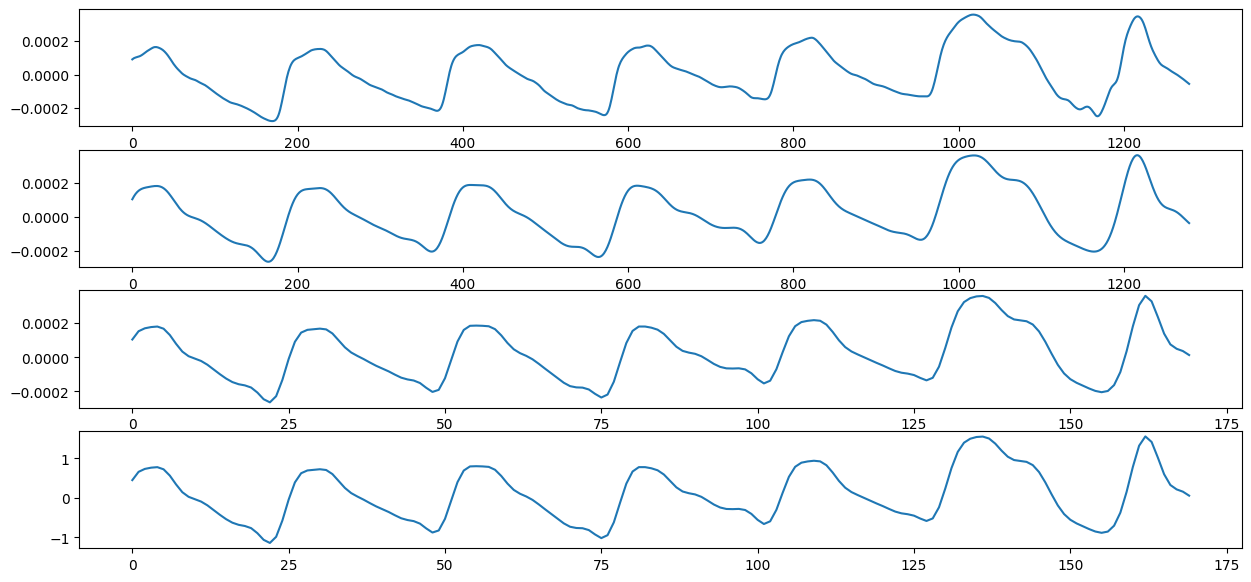

In [5]:
fs = 256
fig, axs = plt.subplots(4, 1, figsize=(15, 7))
axs[0].plot(_prepro.signal[fs*500: fs*505])
axs[1].plot(_prepro.signal_filtered[fs*500: fs*505])
axs[2].plot(_prepro.signal_filtered_downsampled[int(_prepro.fs_downsampled*500): int(_prepro.fs_downsampled*505)])
axs[3].plot(_prepro.signal_filtered_downsampled_standardized[int(_prepro.fs_downsampled*500): int(_prepro.fs_downsampled*505)])

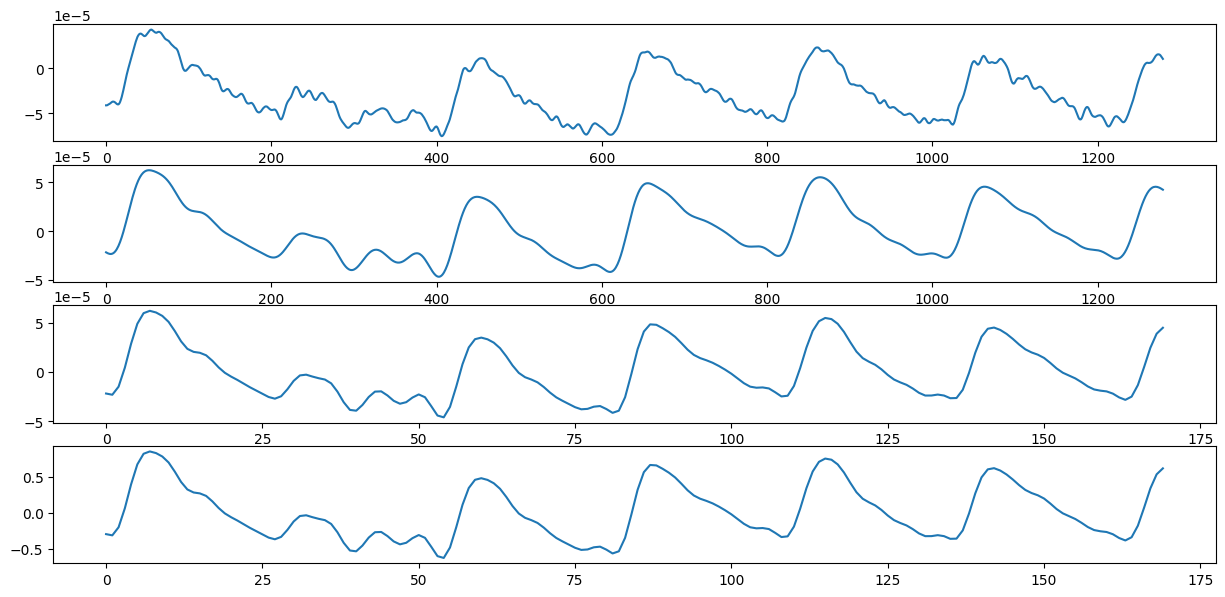

In [ ]:
_prepro = prepro_pipeline_for_single_ppg(signal)

fs = 256
fig, axs = plt.subplots(4, 1, figsize=(15, 7))
axs[0].plot(_prepro.signal[fs*500: fs*505])
axs[1].plot(_prepro.signal_filtered[fs*500: fs*505])
axs[2].plot(_prepro.signal_filtered_downsampled[int(_prepro.fs_downsampled*500): int(_prepro.fs_downsampled*505)])
axs[3].plot(_prepro.signal_filtered_downsampled_standardized[int(_prepro.fs_downsampled*500): int(_prepro.fs_downsampled*505)])

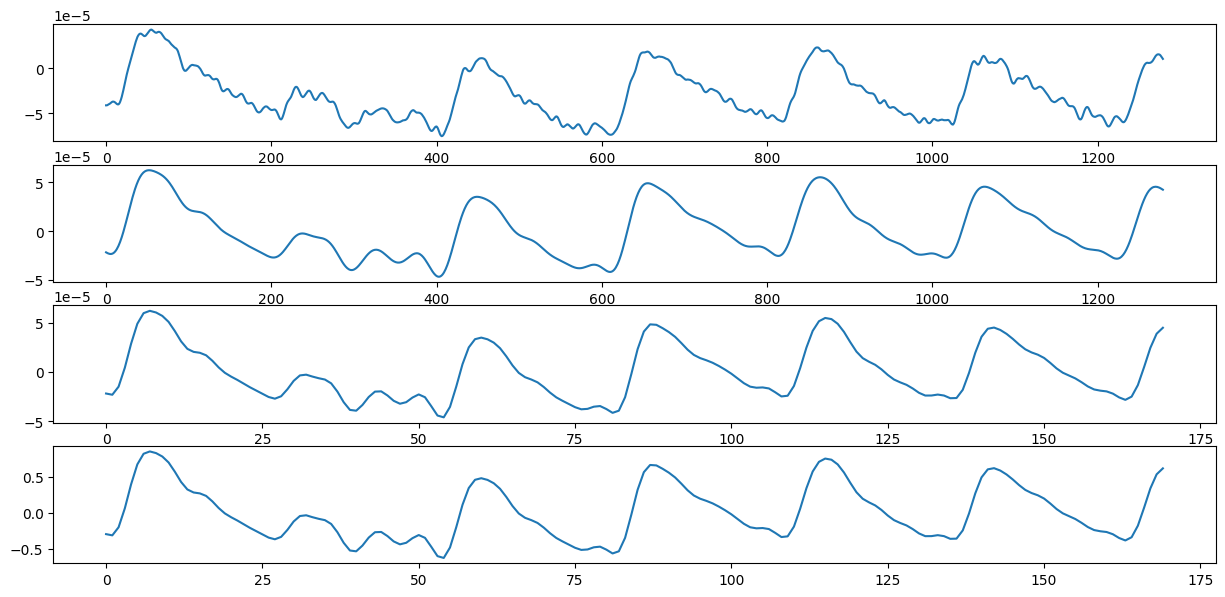

In [47]:
# Filter parameters
order = 8               # 8th order
fs = 256                # Sampling frequency (Hz), adjust as needed
low_cutoff = 0.1        # Low cutoff frequency (Hz)
high_cutoff = 8      # High cutoff frequency (Hz)
stopband_attenuation = 40  # Stopband attenuation (dB)

# Design the Chebyshev Type II filter
nyquist = fs / 2
low_normalized = low_cutoff / nyquist
high_normalized = high_cutoff / nyquist
sos = cheby2(order, stopband_attenuation, [low_normalized, high_normalized], btype='band', analog=False, output='sos')

# Apply the zero-phase filter
signal_filtered = sosfiltfilt(sos, signal)

# Down Sampling
fs_downsampled = 34.13  # 목표 샘플링 주파수 (Hz)

# 시간 벡터 계산 (duration 없이)
n_samples = signal.shape[0]
t_original = np.arange(n_samples) / fs  # 원래 시간 벡터

n_samples_downsampled = int(n_samples * (fs_downsampled / fs))  # 다운샘플링 후 샘플 개수
t_downsampled = np.linspace(0, t_original[-1], n_samples_downsampled)  # 다운샘플링된 시간 벡터

interpolator = interp1d(t_original, signal_filtered, kind='linear')  # 선형 보간 함수 생성
signal_filtered_downsampled = interpolator(t_downsampled)  # 다운샘플링된 신호 생성

signal_filtered_downsampled_standardized = (signal_filtered_downsampled - np.mean(signal_filtered_downsampled)) / np.std(signal_filtered_downsampled)

fig, axs = plt.subplots(4, 1, figsize=(15, 7))
axs[0].plot(signal[fs*500: fs*505])
axs[1].plot(signal_filtered[fs*500: fs*505])
axs[2].plot(signal_filtered_downsampled[int(fs_downsampled*500): int(fs_downsampled*505)])
axs[3].plot(signal_filtered_downsampled_standardized[int(fs_downsampled*500): int(fs_downsampled*505)])

In [44]:
signal_filtered_downsampled.shape

(1474381,)